<a href="https://colab.research.google.com/github/aaronjoseph/NLP_Boiler_Plate/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import os
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
imdb_data = pd.read_csv('IMDB Dataset.csv',error_bad_lines=False,engine='python')
imdb_data = imdb_data.sample(n=5000, random_state=42)

In [ ]:
# Data Cleaning Process
def preprocess(text):
  text=text.lower()
  # remove hyperlinks
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
  #remove hashtag sign
  text=re.sub(r"#","",text)   
  #remove mentions
  text = re.sub(r"(?:\@)\w+", '', text)
  #remove non ascii chars
  text=text.encode("ascii",errors="ignore").decode()
  #remove some puncts (except . ! ?)
  text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
  text=re.sub(r'[!]+','!',text)
  text=re.sub(r'[?]+','?',text)
  text=re.sub(r'[.]+','.',text)
  text=re.sub(r"'","",text)
  text=re.sub(r"\(","",text)
  text=re.sub(r"\)","",text)    
  text=" ".join(text.split())
  return text

def simple_stemmer(text):
  ps=nltk.porter.PorterStemmer()
  text= ' '.join([ps.stem(word) for word in text.split()])
  return text

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
  #set stopwords to english
  stop=set(stopwords.words('english'))
  # Tokenization
  tokenizer=ToktokTokenizer()
  #Setting English stopwords
  stopword_list=nltk.corpus.stopwords.words('english')
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  if is_lower_case:
      filtered_tokens = [token for token in tokens if token not in stopword_list]
  else:
      filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)    
  return filtered_text

In [ ]:
#Apply function
imdb_data['clean']=imdb_data['review'].progress_apply(preprocess)
imdb_data['stem']=imdb_data['clean'].progress_apply(simple_stemmer)
imdb_data['token'] = imdb_data['stem'].progress_apply(remove_stopwords) 


100%|██████████| 5000/5000 [00:00<00:00, 6462.70it/s]

100%|██████████| 5000/5000 [00:19<00:00, 253.69it/s]

100%|██████████| 5000/5000 [00:06<00:00, 794.71it/s]


# Bag of Words & TFIDF

In [ ]:
imdb_data_1 = pd.concat([imdb_data, pd.get_dummies(imdb_data['sentiment'])], axis=1)
# Splitting the data - Into train_test
X = imdb_data_1['token']
y = imdb_data_1['positive']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) 

In [ ]:
# Count Vectorizer for Bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews=cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (4000, 807198)
BOW_cv_test: (1000, 807198)


In [ ]:
# TFIDF
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)
#transformed test reviews
tv_test_reviews=tv.transform(X_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (4000, 807198)
Tfidf_test: (1000, 807198)


In [ ]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,y_train)

In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 1 ... 1 0 0]
[1 1 1 ... 1 0 0]


In [ ]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(y_test,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7468
lr_tfidf_score : 0.7457


In [ ]:
#Classification report for bag of words 
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.75      0.75      4961
    Negative       0.75      0.74      0.75      5039

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.73      0.78      0.75      4961
    Negative       0.77      0.71      0.74      5039

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [ ]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(y_test,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(y_test,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3739 1300]
 [1232 3729]]
[[3566 1473]
 [1070 3891]]


<function matplotlib.pyplot.show>

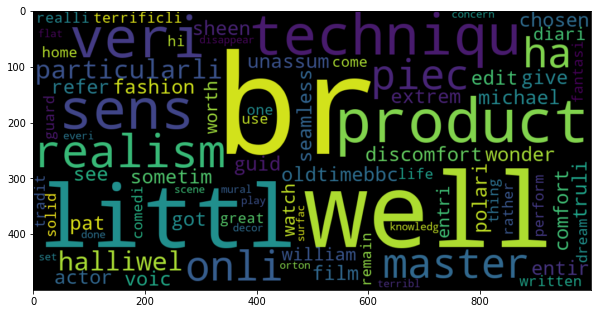

In [ ]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=X[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show